In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics as sklm

In [2]:
def get_predictions(path,gender_split=False):
    """ take a path and returns a dataframe of scores and displays a 
    confusion matrix."""
    # load csv and extract emotion lables
    predict = pd.read_csv(path,index_col='Unnamed: 0')
    predict['pred'] = predict[predict.columns[:-1]].idxmax(axis=1)

    if gender_split==False:
        labels = {'anger':0,'fear':1,'disgust':2,'sad':3,'happy':4,'neutral':5}
        for column in ['true','pred']:
            predict[column] = predict[column].str.split('_',expand=True)[0]
            predict[column] = predict[column].replace(labels)
            
    if gender_split==True:
        labels = ['anger_Male','fear_Male','disgust_Male','sad_Male','happy_Male',
                  'neutral_Male','anger_Female','fear_Female','disgust_Female',
                  'sad_Female','happy_Female','neutral_Female']
        labels = dict([(emo,n) for n, emo in list(enumerate(labels))])
        
        for column in ['true','pred']:
            predict[column] = predict[column].replace(labels)
        
    return predict[['pred','true']],labels

def pre_rec_fsc_scores(true,pred,labels):
    """ Prints accuracy of the model and returns the precision, recall,
    and fscore. """
    accr = sklm.accuracy_score(true,pred)
    print('Model Accuracy: %.2f' % accr)
    prfs = sklm.precision_recall_fscore_support(true,pred)
    scores = pd.DataFrame(prfs,
                          index=['precision','recall','fscore','total_entries'],
                          columns=labels).T
    scores = scores.drop(columns=['total_entries'])
    scores = scores.append(pd.Series(scores.mean(),name='average'))
    scores = scores.round(2)
    return scores

def confusion_matrix(true,pred,labels):
    """ Takes the true and predicted labels and creates a confusion matrix
    annoted with the percent of true values classified in each label"""
    # make a confusion matrix
    cfsn_matrix = sklm.confusion_matrix(true,pred)
    # determine the distribution of true labels as percentage
    percentage = []
    for array in cfsn_matrix:
        percentage.append((array/np.sum(array))*100)
    # heatmap!
    sns.heatmap(percentage,
            annot=percentage,
            fmt='.0f',
            cmap='viridis',
            cbar=False,
            square=True,
            xticklabels = labels,
            yticklabels = labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')

def see_predictions(path,gender_split=False):
    predict, labels = get_predictions(path,gender_split)
    scores = pre_rec_fsc_scores(predict['true'],predict['pred'],labels)
    confusion_matrix(predict['true'],predict['pred'],labels)
    return scores

def compare(left_table,right_table,compare=True,lsuffix='left',rsuffix='right'):
    """ joins two datasets and either returns the join or, if specified, a comparison 
    of each column with left - right """
    # join the two tables
    scores = left_table.join(right_table, lsuffix=lsuffix, rsuffix=rsuffix)
    # return based on specified column
    if compare == True:
        comparison = pd.DataFrame()
        for column in ['precision','recall','fscore']:
            comparison[column]=scores[column+lsuffix] - scores[column+rsuffix]
        return comparison
    else:
        return scores

In [3]:
# this is just so I can easily copy and paste the right path
for file in os.listdir('Data/CSVs/'):
    if 'Predictions' in file:
        print("'Data/CSVs/"+file+"'")
        
fig_path = 'Data/Plots/'

'Data/CSVs/Predictions_Avg_Pool.csv'
'Data/CSVs/Predictions_Avg_Pool_Split.csv'
'Data/CSVs/Predictions_Max_Pool.csv'
'Data/CSVs/Predictions_Max_Pool_Split.csv'
'Data/CSVs/Predictions_Test.csv'


# The Test Set
Taking a quick look at the distribution of the test set

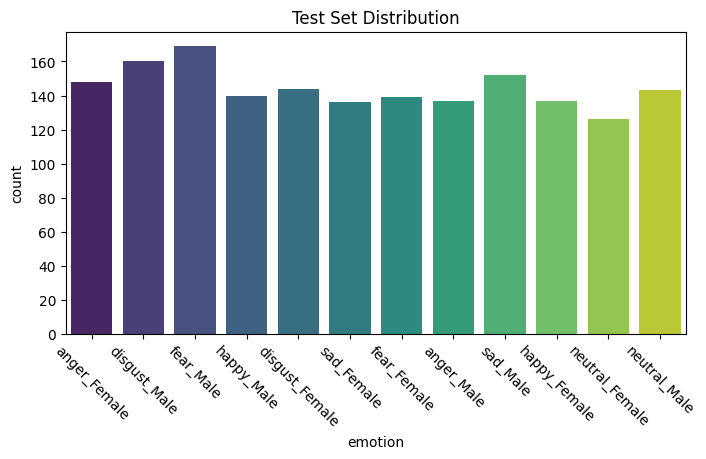

In [4]:
predict = pd.read_csv('Data/CSVs/Predictions_Avg_Pool.csv',index_col='Unnamed: 0')

DIST_TES = plt.figure(figsize=(8,4),dpi=100)
sns.countplot(data=predict,x='true',palette='viridis')
plt.title('Test Set Distribution')
plt.xlabel('emotion')
plt.xticks(rotation=-45)

DIST_TES.savefig(fig_path+'DIST Test Set', bbox_inches='tight');

# Emotion
The following confusion matrices are made such that each row is annotated with what percentage of that label’s emotions were classified as. For example in the average pooling matrix below, of all the anger labeled entries:
- 65% were correctly labeled `anger`
-  3% were incorrectly labeled `fear`
-  13% were incorrectly labeled `disgust`
- etc...


Model Accuracy: 0.57
Model Accuracy: 0.56


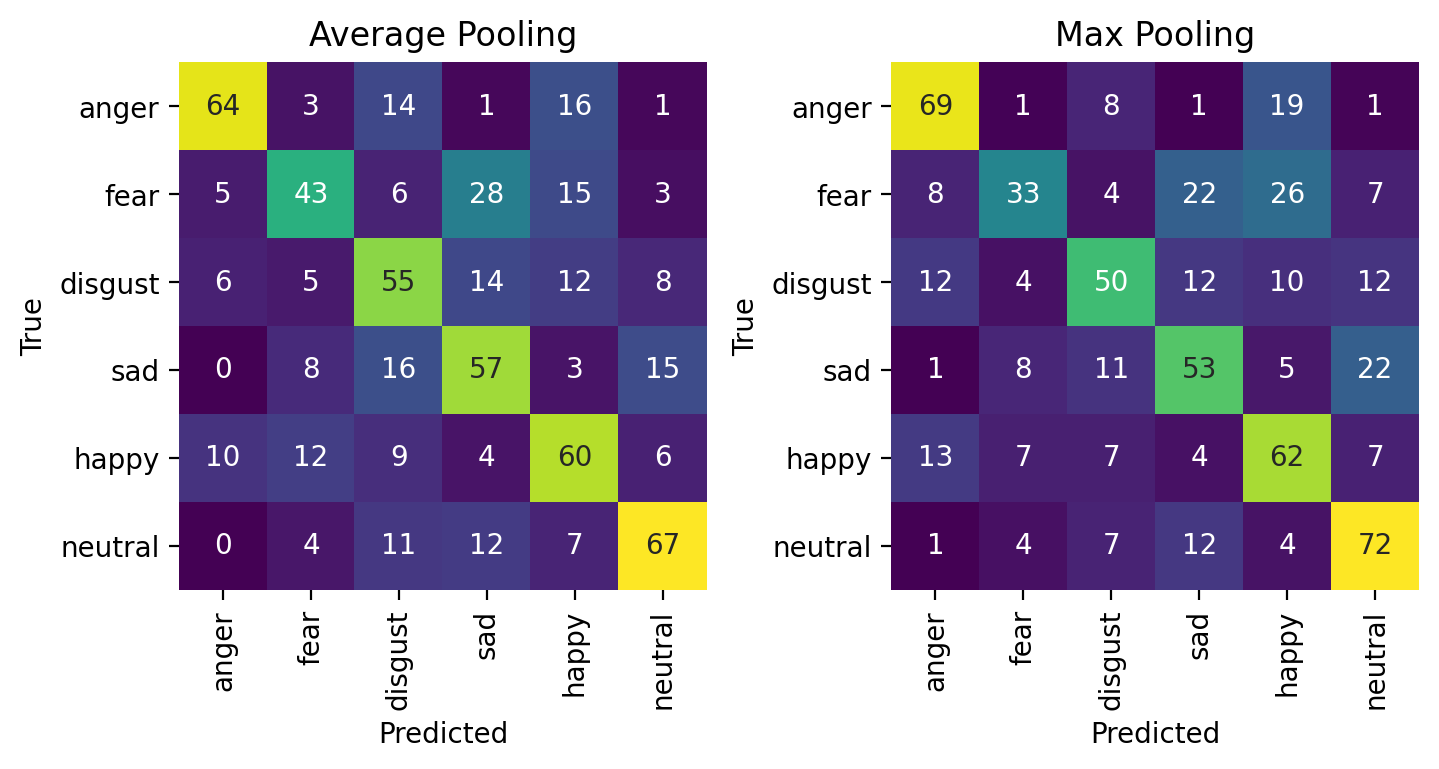

In [5]:
CFM_EMO = plt.figure(figsize=(8,4),dpi=200)
plt.subplots_adjust(wspace=0.35)

plt.subplot(121)
AVG_EM = see_predictions('Data/CSVs/Predictions_Avg_Pool.csv')
plt.title('Average Pooling')

plt.subplot(122)
MAX_EM = see_predictions('Data/CSVs/Predictions_Max_Pool.csv')
plt.title('Max Pooling')

CFM_EMO.savefig(fig_path+'CFM Emotion',bbox_inches='tight');

In [6]:
scores = compare(AVG_EM,MAX_EM,lsuffix='_AVG_EM',rsuffix='_MAX_EM',compare=False)
scores

,precision_AVG_EM,recall_AVG_EM,fscore_AVG_EM,precision_MAX_EM,recall_MAX_EM,fscore_MAX_EM
anger,0.75,0.64,0.69,0.66,0.69,0.68
fear,0.59,0.43,0.49,0.60,0.33,0.43
disgust,0.51,0.55,0.53,0.59,0.50,0.54
sad,0.49,0.57,0.53,0.50,0.53,0.51
happy,0.51,0.60,0.55,0.48,0.62,0.54
neutral,0.65,0.67,0.66,0.57,0.72,0.64
average,0.58,0.58,0.58,0.57,0.57,0.56


In [7]:
compare(AVG_EM,MAX_EM,lsuffix='_AVG_EM',rsuffix='_MAX_EM')
# Positive means AVG_EM > MAX_EM

,precision,recall,fscore
anger,0.09,-0.05,0.01
fear,-0.01,0.10,0.06
disgust,-0.08,0.05,-0.01
sad,-0.01,0.04,0.02
happy,0.03,-0.02,0.01
neutral,0.08,-0.05,0.02
average,0.01,0.01,0.02


Overall, the models trained on the six emotion labels seem to have similar accuracy, with the average pool model AVG_EM scoring slightly higher than the max pool model MAX_EM. While this is true for most emotions it does appear that Max_EM is slightly better at determining `disgust`.

Some other interesting information:
- Both models tended to overlabled emotions as `sad` and `happy`.
- Both also seemed to struggle the most to classify `fear`.
- Lastly, both models were best at labeling `anger`.


# Emotion & Gender

Model Accuracy: 0.58
Model Accuracy: 0.55


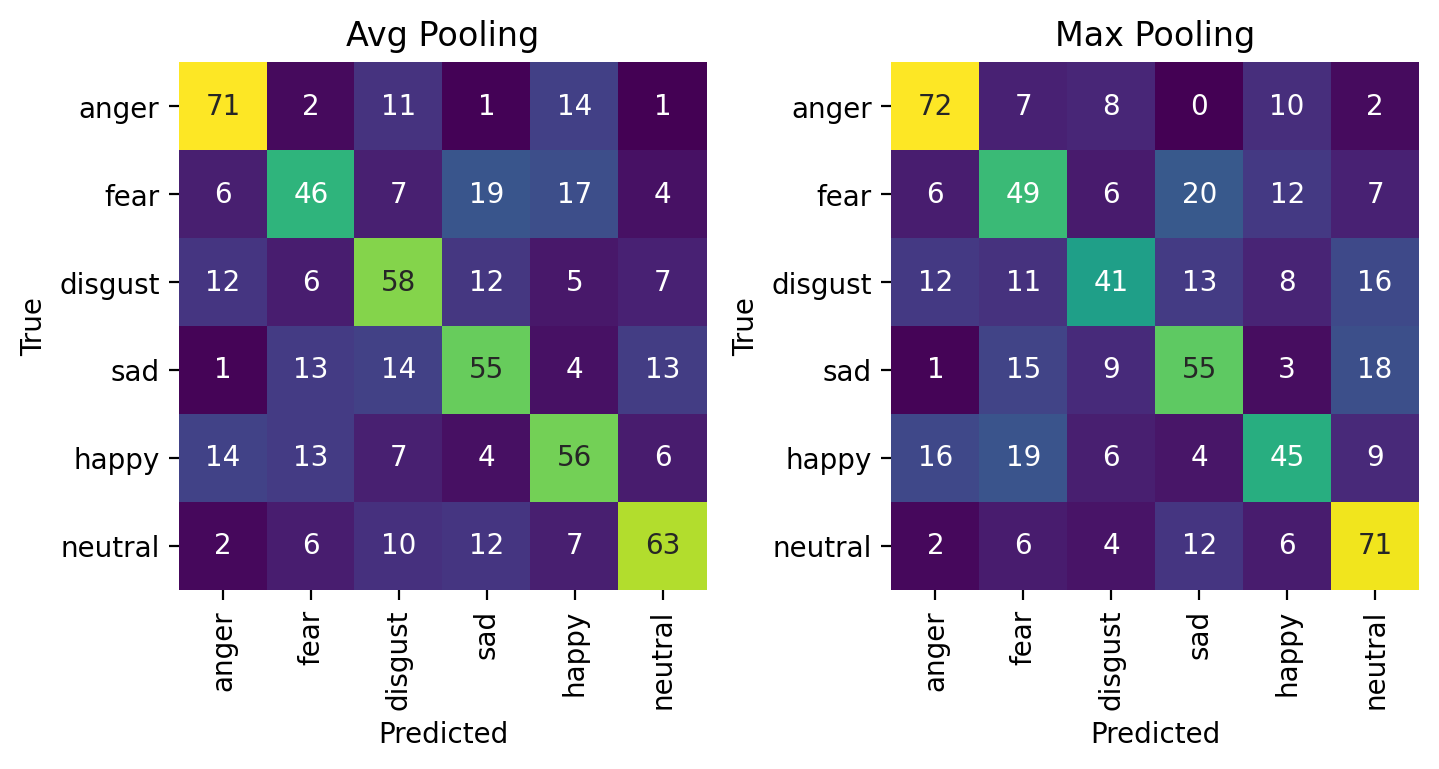

In [8]:
CFM_EMG = plt.figure(figsize=(8,4),dpi=200)
plt.subplots_adjust(wspace=0.35)

plt.subplot(121)
AVG_SG = see_predictions('Data/CSVs/Predictions_Avg_Pool_Split.csv')
plt.title('Avg Pooling')

plt.subplot(122)
MAX_SG = see_predictions('Data/CSVs/Predictions_Max_Pool_Split.csv')
plt.title('Max Pooling')

CFM_EMG.savefig(fig_path+'CFM Emotion_Gender',bbox_inches='tight');

In [9]:
compare(AVG_SG,MAX_SG,lsuffix='_AVG_SG',rsuffix='_MAX_SG',compare=False)

,precision_AVG_SG,recall_AVG_SG,fscore_AVG_SG,precision_MAX_SG,recall_MAX_SG,fscore_MAX_SG
anger,0.66,0.71,0.68,0.66,0.72,0.69
fear,0.55,0.46,0.50,0.48,0.49,0.48
disgust,0.56,0.58,0.57,0.57,0.41,0.47
sad,0.53,0.55,0.54,0.52,0.55,0.53
happy,0.53,0.56,0.54,0.53,0.45,0.49
neutral,0.65,0.63,0.64,0.56,0.71,0.62
average,0.58,0.58,0.58,0.55,0.55,0.55


The average pooling model AVG_SG scored much higher than MAX_SG which scored even lower than its emotion-alone counterpart. It seems to share most of the same qualities as the previous two models, so I'm going to spend more time comparing AVG_SG with AVG_EM.

# Average Pool

Model Accuracy: 0.57
Model Accuracy: 0.58


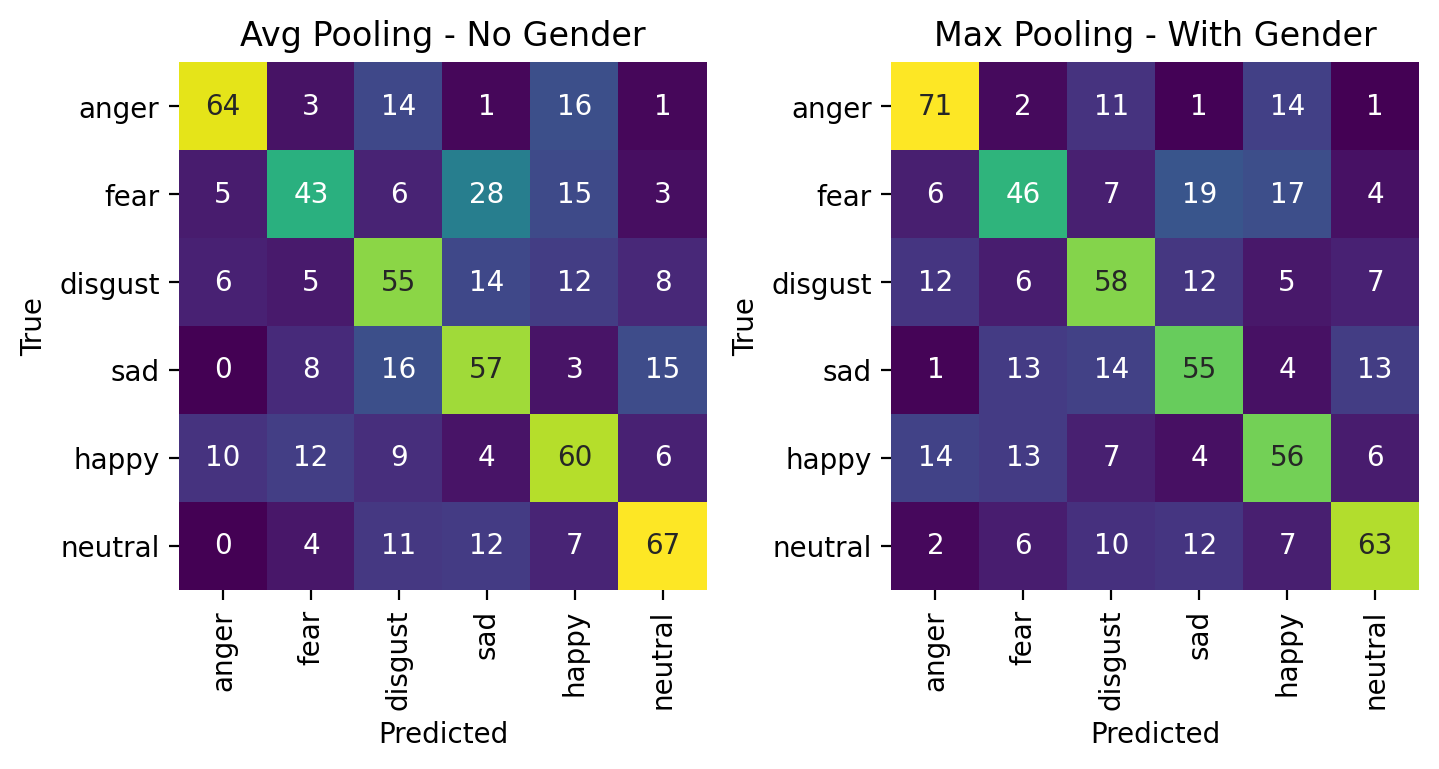

In [10]:
CFM_AVP = plt.figure(figsize=(8,4),dpi=200)
plt.subplots_adjust(wspace=0.35)

plt.subplot(121)
AVG_EM = see_predictions('Data/CSVs/Predictions_Avg_Pool.csv')
plt.title('Avg Pooling - No Gender')

plt.subplot(122)
AVG_SG = see_predictions('Data/CSVs/Predictions_Avg_Pool_Split.csv')
plt.title('Max Pooling - With Gender')

CFM_AVP.savefig(fig_path+'CFM Average Pooling',bbox_inches='tight');

In [11]:
compare(AVG_EM,AVG_SG,lsuffix='_AVG_EM',rsuffix='_MAX_EM')

,precision,recall,fscore
anger,0.09,-0.07,0.01
fear,0.04,-0.03,-0.01
disgust,-0.05,-0.03,-0.04
sad,-0.04,0.02,-0.01
happy,-0.02,0.04,0.01
neutral,0.00,0.04,0.02
average,0.00,0.00,0.00


Seem that the two models are really similar, with AVG_SG having slightly better scores for `fear`, `disgust`, and `sad`. Since these two are so even, would it do even better is the results were combined?

# Average Pool Combination

Model Accuracy: 0.59


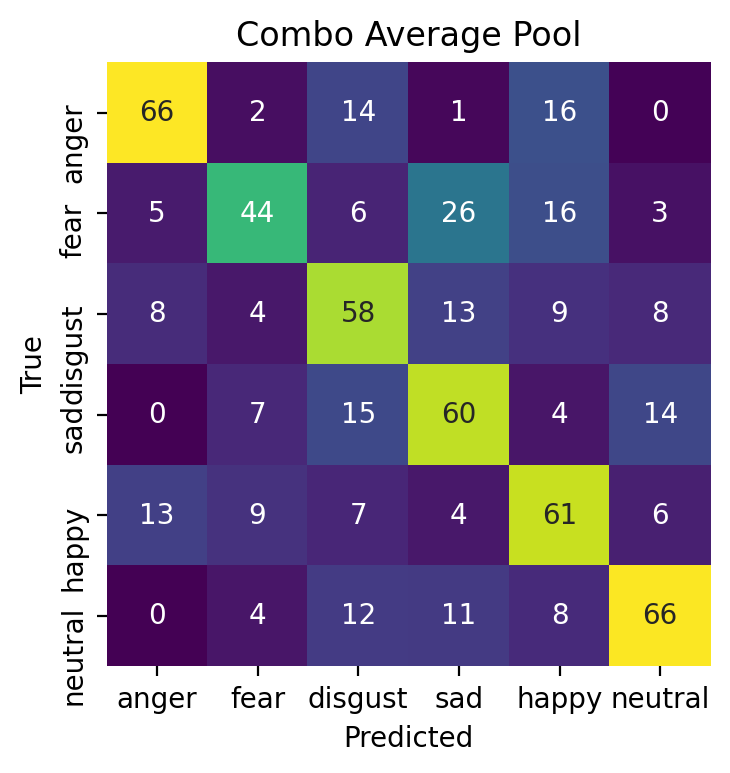

In [12]:
AVG_SG_pred = pd.read_csv('Data/CSVs/Predictions_Avg_Pool_Split.csv',index_col='Unnamed: 0')
AVG_EM_pred = pd.read_csv('Data/CSVs/Predictions_Avg_Pool.csv',index_col='Unnamed: 0')

og_columns = AVG_SG_pred.columns[:-1]
emotions = np.unique(np.array([col.split('_')[0] for col in og_columns]))
labels = {'anger':0,'fear':1,'disgust':2,'sad':3,'happy':4,'neutral':5}

final = AVG_SG_pred[['true']].loc[:]

for emotion in emotions:
    AVG_SG_pred[emotion] = (AVG_SG_pred[emotion+'_Male'] + AVG_SG_pred[emotion+'_Female'])/2
    final[emotion] = (AVG_SG_pred[emotion]+AVG_EM_pred[emotion])/2
    
final['pred'] = final[final.columns[1:]].idxmax(axis=1)
final['true'] = final['true'].str.split('_',expand=True)[0]

for column in ['true','pred']:
    final[column] = final[column].replace(labels)
    
final_scores = pre_rec_fsc_scores(final['true'],final['pred'],labels)

CFM_CMB = plt.figure(figsize=(4,4),dpi=200)
confusion_matrix(final['true'],final['pred'],labels)
plt.title('Combo Average Pool')

CFM_CMB.savefig(fig_path+'CFM Combo', bbox_inches='tight');

In [13]:
final_scores

,precision,recall,fscore
anger,0.72,0.66,0.69
fear,0.64,0.44,0.52
disgust,0.54,0.58,0.56
sad,0.51,0.60,0.55
happy,0.52,0.61,0.56
neutral,0.66,0.66,0.66
average,0.60,0.59,0.59


compared to AVG_SG

In [14]:
compare(final_scores,AVG_SG,lsuffix='_final',rsuffix='_AVG_SG')

,precision,recall,fscore
anger,0.06,-0.05,0.01
fear,0.09,-0.02,0.02
disgust,-0.02,0.00,-0.01
sad,-0.02,0.05,0.01
happy,-0.01,0.05,0.02
neutral,0.01,0.03,0.02
average,0.02,0.01,0.01


compared to AVG_EM

In [15]:
compare(final_scores,AVG_EM,lsuffix='_final',rsuffix='_AVG_EM')

,precision,recall,fscore
anger,-0.03,0.02,0.00
fear,0.05,0.01,0.03
disgust,0.03,0.03,0.03
sad,0.02,0.03,0.02
happy,0.01,0.01,0.01
neutral,0.01,-0.01,0.00
average,0.02,0.01,0.01


Overall, this combination model seems to be a good balance between the two average pool models but only boosts the accuracy by 1%. I'll move forwards with this combination model.

# Full Gender Split Matrix
For reference, the full emotion and gender matrices. 

Model Accuracy: 0.56
Model Accuracy: 0.51


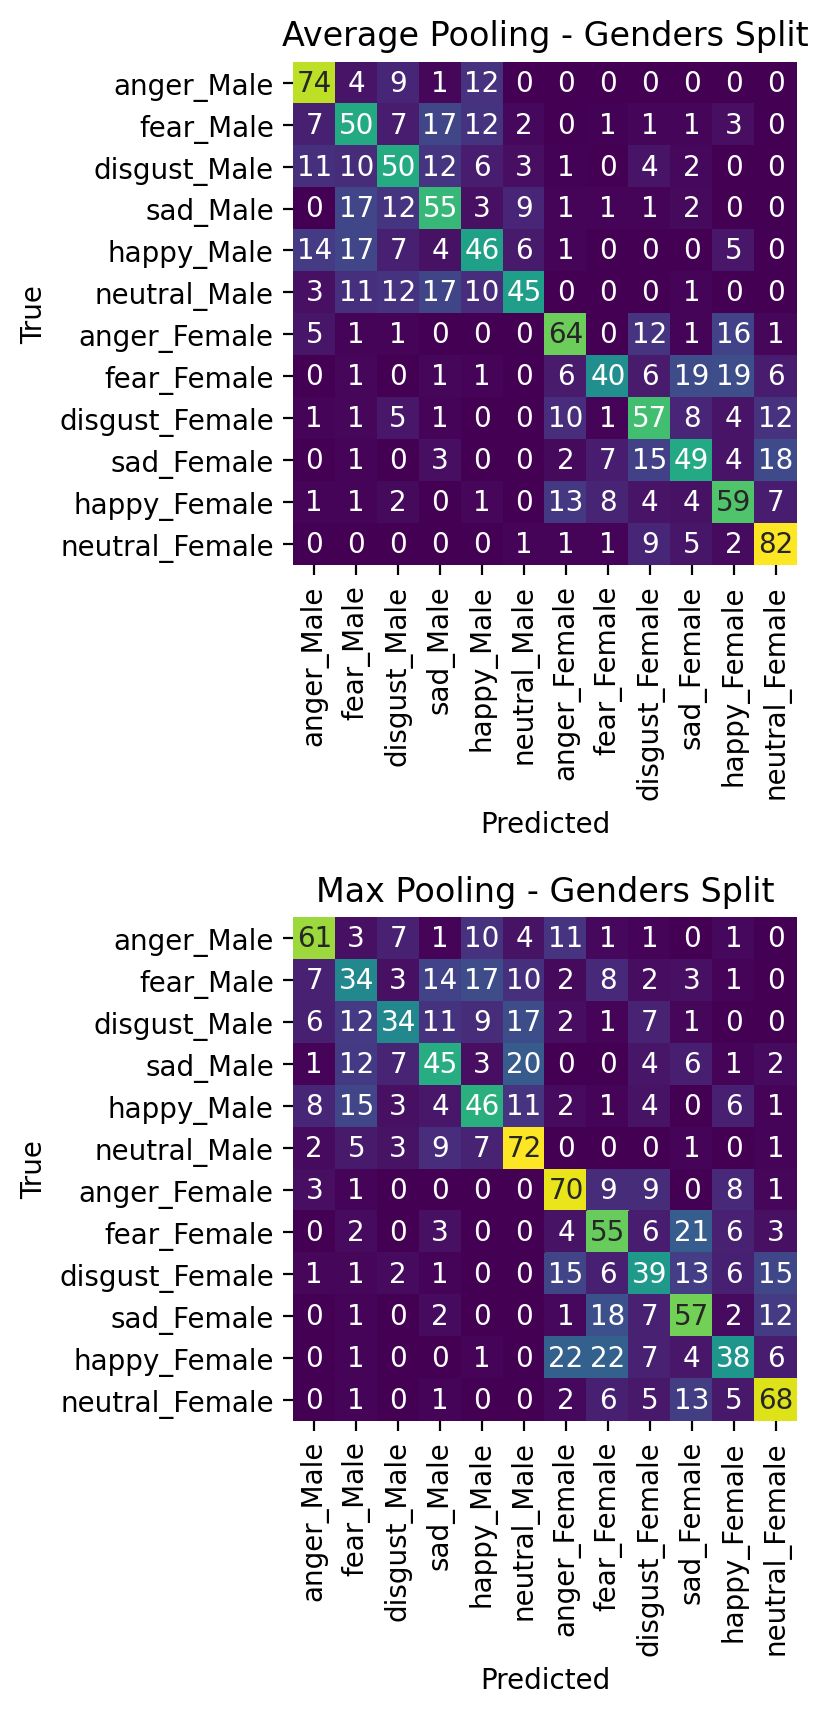

In [16]:
CFM_SGF = plt.figure(figsize=(4,9),dpi=200)
plt.subplots_adjust(hspace=0.7)

plt.subplot(211)
see_predictions('Data/CSVs/Predictions_Avg_Pool_Split.csv',gender_split=True)
plt.title('Average Pooling - Genders Split')

plt.subplot(212)
see_predictions('Data/CSVs/Predictions_Max_Pool_Split.csv',gender_split=True)
plt.title('Max Pooling - Genders Split')
CFM_SGF.savefig(fig_path+'CFM Full Split',bbox_inches='tight');